#Early Genre Detection

##Sources

- https://medium.com/@etown/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52
- https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
- https://github.com/sevenfx/fastai_audio


# Download and extract audio data

In [0]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!unzip fma_metadata.zip

!curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip
!unzip fma_small.zip

In [0]:
import pandas as pd

def id_to_path(mp3id):
  mp3id = "00000" + str(mp3id)
  mp3id = mp3id[len(mp3id)-6:len(mp3id)]
  return f"fma_small/{mp3id[0:3]}/{mp3id}.mp3"

df = pd.read_csv("/content/fma_metadata/tracks.csv")
df = df[['Unnamed: 0', 'track.7']].iloc[2:]
df['path'] = df['Unnamed: 0'].apply(id_to_path)
df['genre'] = df['track.7']
df = df[['path', 'genre']]
df.reset_index(inplace = True, drop = True)
df = df[~df['genre'].isnull()]
#df = df[10000:20000]
df.head()

In [0]:
!rm -rf fma_imagenet

In [0]:
import os
from shutil import copyfile

for genre in df['genre'].unique():
  os.makedirs('fma_imagenet/audio/' + genre)
  
for index, row in df.iterrows():
  path = row['path']
  genre = row['genre']
  new_path = 'fma_imagenet/audio/' + genre + '/' + path.split('/')[2]
  if os.path.exists(path):
    copyfile(path, new_path)

In [16]:
!ls fma_imagenet/audio/

 Blues		   Electronic	  Hip-Hop	  Jazz	       Rock
 Classical	   Experimental   Instrumental	 'Old-Time '   Soul-RnB
'Easy Listening'   Folk		  International   Pop	       Spoken


Let's listen to a sound

In [17]:
import IPython
IPython.display.Audio("/content/fma_imagenet/audio/Electronic/026651.mp3")

All audio samples are 4 seconds long which fits well with our spectrogram method.

# Process the data and create spectrograms

In [0]:
labels  = df['genre'].unique()

In [0]:
!rm -rf 'fma_imagenet/spectrogram'

In [0]:
!mkdir 'fma_imagenet/spectrogram'

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
from fastai import *


def create_spectrograms(fold):
    spectrogram_path = Path('fma_imagenet/spectrogram/')  
    audio_path = Path('fma_imagenet/audio/')  
    print(f'Processing genre {fold}')
    os.mkdir(spectrogram_path/fold)
    for audio_file in tqdm(list(Path(audio_path/f'{fold}').glob('*.mp3'))):
    # for subdir, dirs, files in os.walk(audio_path):
    #   for audio_file in files:
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.mp3','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [23]:
import multiprocessing
multiprocessing.cpu_count()

2

In [0]:
 import multiprocessing
 with multiprocessing.Pool() as pool:
        pool.map(create_spectrograms, labels)

# for genre in labels:
#   create_spectrograms(genre)

In [0]:
from shutil import copyfile
copyfile('/content/')

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Create ImageNet style directory structure for each of the folds for easy data loading

#Messed Up Directories

In [0]:
!rm -rf 'fma_imagenet/data'

In [0]:
!mkdir 'fma_imagenet/data'

In [0]:
import os
import glob
import shutil
from pathlib import Path  
data_path = Path('fma_imagenet/data/') 
spectrogram_path = Path('fma_imagenet/spectrogram/')  
def create_fold_directory(fold):
    png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
    os.mkdir(data_path/fold)
    os.mkdir(data_path/fold/'train')
    os.mkdir(data_path/fold/'valid')
    for label in labels:
        os.mkdir(data_path/fold/'train'/label)
        os.mkdir(data_path/fold/'valid'/label)
     
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name) 

In [0]:
for i in range(len(labels)):
    create_fold_directory(str(i))

First let's take a look at some of the data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [0]:
path = Path('fma_imagenet/data/1/train/Electronic')
path.ls()

In [0]:
data_directory.ls()

# Swiss Army Knife

In [10]:
from fastai import *
from fastai.vision import *
data_directory = Path('/content/fma_imagenet/')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# data = (ImageImageList
#         .from_folder(data_directory, ['.png','.jpg'])
#         .split_by_rand_pct()
#         .label_from_folder()
#         .databunch(bs=64))
data = ImageDataBunch.from_folder(data_directory, train='spectrogram' , valid_pct=0.1, bs=32, ds_tfms=[], size=224)
data.normalize(imagenet_stats)    

ImageDataBunch;

Train: LabelList (1114 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Folk,Folk,Folk,Folk,Folk
Path: /content/fma_imagenet;

Valid: LabelList (123 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
International,International,International,International,Experimental
Path: /content/fma_imagenet;

Test: None

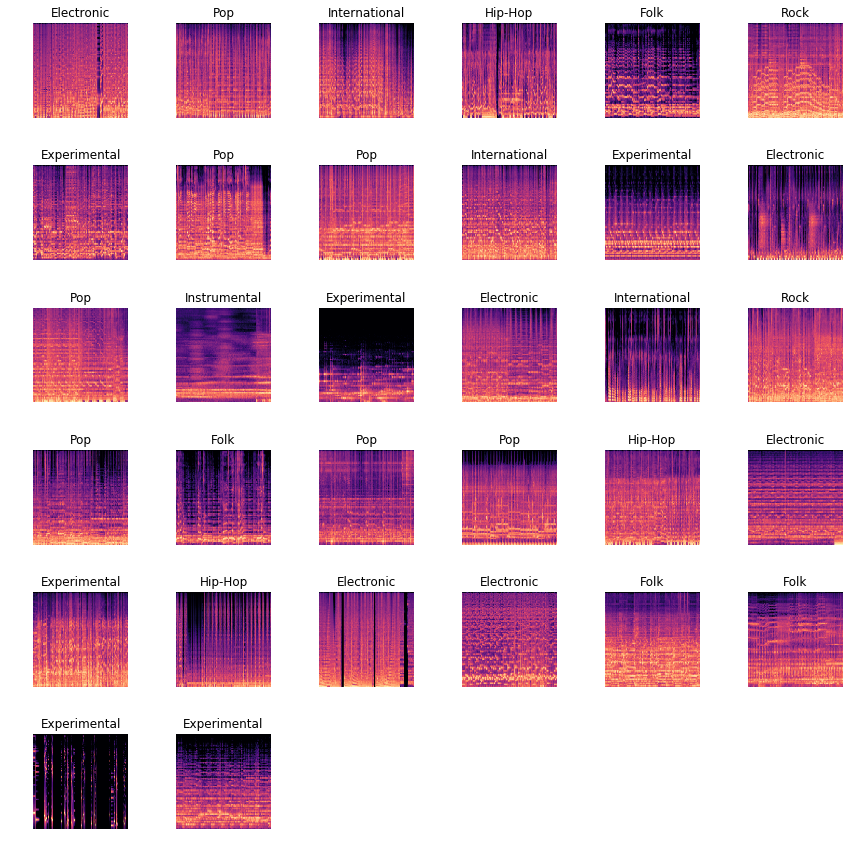

In [11]:
data.show_batch(rows=6, figsize=(12,12))

In [0]:
# !pip install wandb
# !wandb login

In [13]:
import wandb
from wandb.fastai import WandbCallback

wandb.init()

W&B Run: https://app.wandb.ai/ajayuppili/uncategorized/runs/usncmnm6

In [0]:
learn = cnn_learner(data, models.densenet121, metrics=[accuracy, FBeta(beta=1)], callback_fns=WandbCallback)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


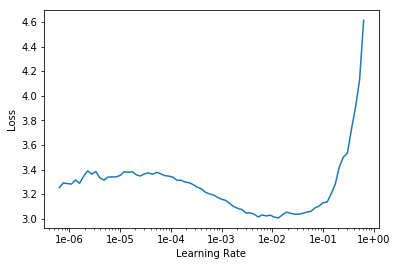

In [15]:
#learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
#learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-4, 1e-2))
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=1e-3)

/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with valid_loss value: 1.9725605249404907.
Better model found at epoch 1 with valid_loss value: 1.8102519512176514.
Loaded best saved model from /content/wandb/run-20191006_194850-usncmnm6/bestmodel.pth


Better model found at epoch 0 with valid_loss value: 1.842549204826355.
Better model found at epoch 3 with valid_loss value: 1.7974882125854492.
Better model found at epoch 4 with valid_loss value: 1.7278130054473877.
Better model found at epoch 6 with valid_loss value: 1.714072823524475.
Better model found at epoch 7 with valid_loss value: 1.553832769393921.
Better model found at epoch 8 with valid_loss value: 1.5328189134597778.
Loaded best saved model from /content/wandb/run-20191006_194850-usncmnm6/bestmodel.pth


In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

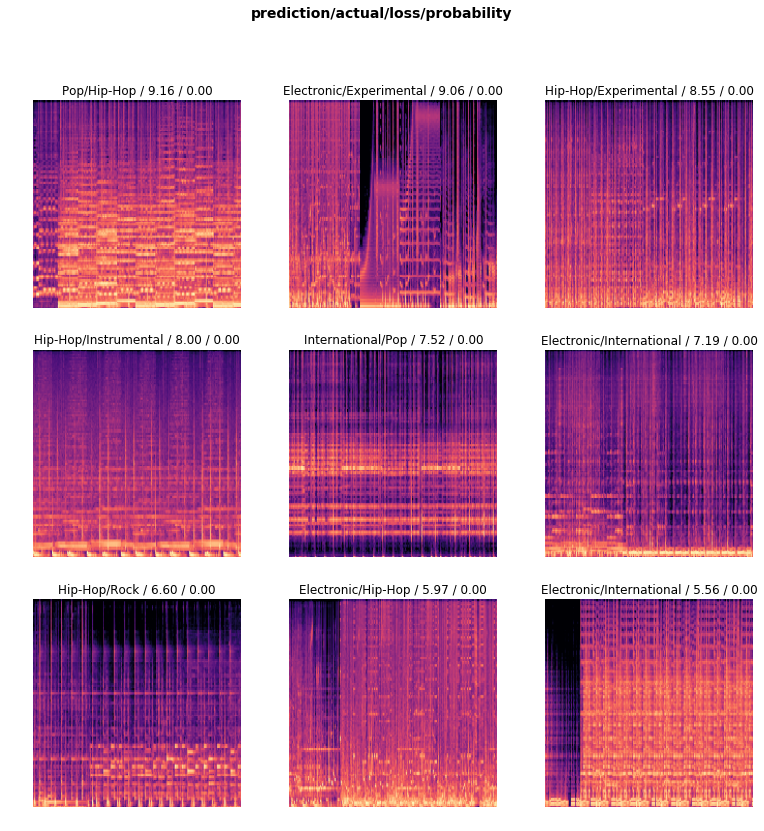

In [18]:
interp.plot_top_losses(9, figsize=(13,13))

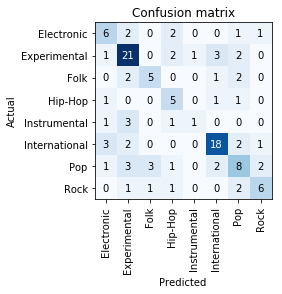

In [19]:
interp.plot_confusion_matrix()